Na dzisiejszych zajęciach prześledzimy poszczególne kroki przy pracy nad algorytmem uczenia maszynowego - ten schemat będzie nam towarzyszył przez większość zajęć. Będziemy budować klasyfikator do wykrywania chorób krtani.

W folderze dane_testowe znajdują się pliki .WAV z nagraniami mowy. Nazwa pliku składa się z ID osoby nagranej oraz treści nagrania: 'phrase', gdy osoba mówi całą frazę oraz nazwa samogłoski, gdy wypowiada jedynie samogłoskę (w tym przypadku dodatkowo określona jest wysokość dźwięku - wysoki 'h', niski 'l' lub normalny 'n').
Źródło danych: http://stimmdb.coli.uni-saarland.de

Plik .zip wgrany do przestrzeni roboczej można wypakować bezpośrednio w notebooku:

In [132]:
# !unzip dane_testowe.zip -d dane_testowe # opcja -d służy do podania docelowego katalogu

In [133]:
# Zacznij tutaj od importu potrzebnych bibliotek.
from scipy.io.wavfile import read as read_wav
from scipy.signal import ShortTimeFFT
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt

1. Utwórz listę plików, które zawierają nagrania osób o ID wymienionych poniżej:

`ids_to_get = [1, 10, 95, 110, 121, 144, 676, 699, 888, 910, 1182, 1204, 1207, 1528, 1860, 1897, 1972, 2102, 2152, 2444]`

Sprawdź, ile jest tych plików.

In [134]:
ids_to_get = [1, 10, 95, 110, 121, 144, 676, 699, 888, 910, 1182, 1204, 1207, 1528, 1860, 1897, 1972, 2102, 2152, 2444]
all_files = os.listdir('dane_testowe')
# filtruj pliki do tych, które w nazwie mają ID z ids_to_get
files = [f for f in all_files if int(f.split('-')[0]) in ids_to_get]
# files

In [135]:
print(f"Liczba plików: {len(files)}")

Liczba plików: 26


2. Do dalszych analiz weź jedynie pliki zawierające całą frazę (a nie pojedyncze samogłoski). Utwórz listę takich plików, zapisz ją do pliku (.TXT lub dowolnego innego, np. używając funkcji `np.save` lub `np.savetxt`).

In [136]:
files_phrase = [f for f in files if 'phrase' in f]
np.savetxt('files_phrase.txt', files_phrase, fmt='%s')

3. Wczytaj pliki .WAV, które znajdują się na powyższej liście i sprawdź, jaką mają częstotliwość próbkowania, np. używając funkcji [`scipy.io.wavfile.read`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) (`from scipy.io.wavfile import read as read_wav`). 

    Teraz wystarczy sprawdzić dla jednego sygnału - wszystkie mają taką samą. Przy pracy z nowymi danymi, o których tego nie wiemy, należy sprawdzić, czy na pewno częstotliwość próbkowania wszystkich sygnałów jest taka sama, i w razie potrzeby ją odpowiednio zmienić.

In [137]:
files_phrase = np.loadtxt('files_phrase.txt', dtype=str)
fs, data = read_wav(os.path.join('dane_testowe', files_phrase[0]))

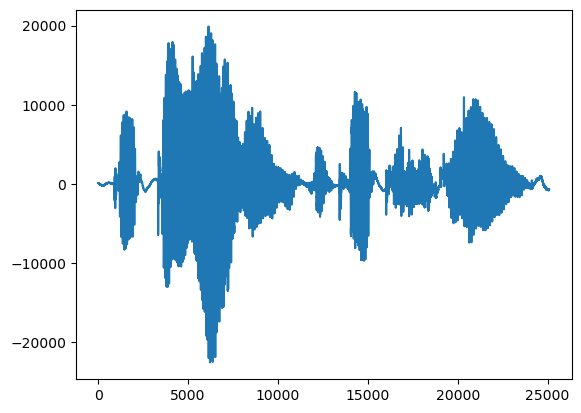

In [138]:
plt.plot(data)

Jeśli chcesz usprawnić pracę w kolejnych zadaniach, możesz zapisać kod wczytujący pliku do skryptu .py - przyda się w kolejnych zadaniach, a dzięki temu nie będzie konieczne kopiowanie kodu (wystarczy zaimportować plik w taki sam sposób, jak biblioteki). Przykładowo zapisujemy plik `my_utils.py` o zawartości:

```
from scipy.io.wavfile import read as read_wav
def read_wavs():
    #kod wczytujący wavy z listy plików
```

W kolejnym notebooku wystarczy wtedy wpisać: `from my_utils import read_wavs` i możemy korzystać z napisanej funkcji (warunek: `my_utils.py` jest w naszym katalogu roboczym). Tworzenie takich plików z operacjami, które często powtarzamy, usprawnia pracę i pomaga uniknąć błędów przy kopiowaniu fragmentów kodu.

4. Oblicz i wyświetl spektrogram dowolnego sygnału, np. używając funkcji `spectrogram` dla klasy [`ShortTimeFFT`](https://docs.scipy.org/doc//scipy-1.16.2/reference/generated/scipy.signal.ShortTimeFFT.html) z biblioteki scipy (`from scipy.signal import ShortTimeFFT`). Sprawdź, jakie wymiary ma macierz zawierająca spektrogram.

In [139]:
STFT = ShortTimeFFT.from_window('hann', fs=fs, nperseg=256, noverlap=128, mfft=1024)
S = STFT.spectrogram(data)
t = STFT.t(len(data))
f = STFT.f

Text(0, 0.5, 'Częstotliwość [Hz]')

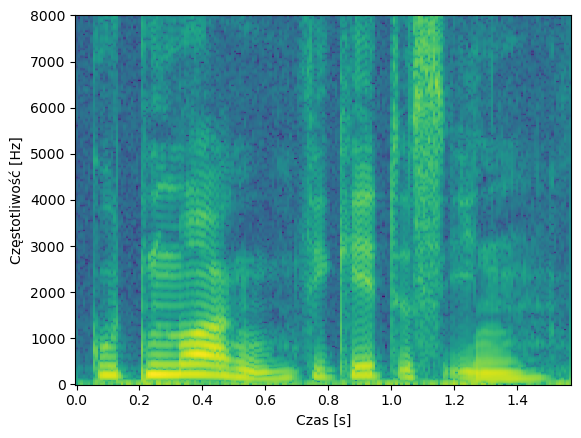

In [154]:
plt.pcolormesh(t, f, 10*np.log10(S))
plt.xlabel('Czas [s]')
plt.ylabel('Częstotliwość [Hz]')

5. Oblicz spektrogramy pozostałych sygnałów i umieść je w jednej macierzy 3D (liczba sygnałów $\times$ liczba pasm częstotliwości $\times$ liczba ramek).

    Uwaga na długości sygnałów - nie są takie same, więc trzeba albo przyciąć wszystkie spektrogramy do długości liczby ramek najkrótszego, albo wszystkie uzupełnić zerami (tzw. zero-padding) do długości najdłuższego.

In [206]:
spectrograms = []
for file in files_phrase:
    fs, data = read_wav(os.path.join('dane_testowe', file))
    STFT = ShortTimeFFT.from_window('hann', fs=fs, nperseg=256, noverlap=128, mfft=1024)
    S = STFT.spectrogram(data)
    spectrograms.append(S)

# expand all spectrograms to the same shape by padding with zeros
max_len = max(S.shape[1] for S in spectrograms)
spectrograms_padded = []
for S in spectrograms:
    pad_width = max_len - S.shape[1]
    if pad_width > 0:
        # pad zeros on the right (time axis)
        S_padded = np.pad(S, ((0, 0), (0, pad_width)), mode='constant')
    else:
        S_padded = S
    spectrograms_padded.append(S_padded)

spectrograms_3d = np.stack(spectrograms_padded, axis=0)
print(spectrograms_3d.shape)


(20, 513, 355)


6. Plikom z nagraniami osób o  `ID = [110, 144, 888, 910, 1204, 1897, 1972, 2102, 2152, 2444]` przyporządkuj etykietę 1, pozostałym etykietę 0. Wykorzystaj stworzoną wcześniej listę plików, żeby mieć pewność, że do każdego sygnału przypisana jest właściwa etykieta (utwórz wektor zawierający etykiety w takiej kolejności, w jakiej są odpowiednie dane w utworzonej przed chwilą macierzy cech (spektrogramów)).

Dane należy podzielić na zbiór uczący, na którym będzie prowadzony trening klasyfikatora, oraz zbiór testowy, na którym będzie prowadzona ewaluacja. Dzielimy zarówno macierz z danymi (wyekstrahowanymi cechami) jak i wektor etykiet. Zbiory uczący i testowy zawsze oznacza się jako `X_train` i `X_test`, a ich etykiety jako `y_train` i `y_test`.

7. Podziel teraz macierz cech oraz wektor etykiet na zbiór uczący i testowy w stosunku $8:2$. Możesz to zrobić funkcją [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split) z biblioteki sklearn. Zadbaj o stratyfikację danych (czyli podział na zbiory w taki sposób, żeby zachowany był rozkład poszczególnych klas w obu tworzonych zbiorach), podając argument `stratify=labels` (nazwa zmiennej z etykietami). Jaki wpływ na uzyskany klasyfikator może mieć pominięcie stratyfikacji? Sprawdź, jak wygląda podział na zbiór treningowy i testowy przy różnych wartościach `random_state` z uwzględnieniem stratyfikacji i bez.

    Zapisz listę plików z obu zbiorów do plików tekstowych - przyda się w kolejnym zadaniu.

    (Podpowiedź: możesz skorzystać z tego, że funkcja `train_test_split` przyjmuje dowolną liczbę macierzy)

8. „Spłaszcz” dane, żeby z dwuwymiarowego spektrogramu uzyskać wektor - większość klasyfikatorów nie przyjmuje na wejściu obrazów (danych 2D), więc ten krok jest konieczny.

    Podpowiedź: `X_train` powinien mieć po tej operacji wymiary liczba_plików $\times$ (liczba_ramek $\cdot$ liczba_pasm_częstotliwości).

9. Spróbuj wytrenować klasyfikator oraz przeprowadzić predykcję na zbiorze testowym. Na początek użyjemy metody [k najbliższych sąsiadów](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) (`from sklearn.neighbors import KNeighborsClassifier`).

In [141]:
model = KNeighborsClassifier() #podaj parametry modelu
    
model.fit() # jakie argumenty są potrzebne?

TypeError: KNeighborsClassifier.fit() missing 2 required positional arguments: 'X' and 'y'

10. Zapisz klasyfikator do pliku przy użyciu pickle'a. Spróbuj go potem wczytać (przypisując go do nowej zmiennej, żeby w razie czego nie nadpisać sobie działającego modelu).

11. Teraz przeprowadź predykcję na danych testowych, czyli podaj do funkcji `X_test` i zobacz, do jakich klas zostaną przyporządkowane obiekty. Nie używamy wektora `y_test` - on służy jedynie do sprawdzenia, czy predykcje są prawidłowe.

In [ ]:
preds = model.predict(X_test)

Mając wytrenowany klasyfikator trzeba sprawdzić, czy on się w ogóle do czegoś nadaje, czyli czy ma zdolność do uogólniania zależności widocznych w zbiorze uczącym tak, żeby na zbiorze testowym również uzyskać dobre wyniki.

Klasyfikator należy spróbować ocenić w sposób obiektywny - do tego służą tzw. metryki sukcesu, które określają, jak dobrze klasyfikator potrafi klasyfikować obiekty należące do poszczególnych klas - czy jest tak samo dobry w przypadku każdej z analizowanych klas, czy może lepiej radzi sobie z jedną z nich. Takich metryk jest stosunkowo dużo, są wymienione w dokumentacji biblioteki scikit-learn: 

https://scikit-learn.org/stable/modules/model_evaluation.html

Zacznijmy od wyznaczenia i analizy macierzy pomyłek. W przypadku klasyfikacji binarnej (z tylko dwiema klasami, zazwyczaj oznaczanymi etykietami 0 i 1 lub słownie *negative* i *positive*) jest to macierz, w której zliczone są wyniki klasyfikacji podzielone na 4 grupy:

- prawdziwie pozytywne, TP (ang. *true positive*) - obiekt z klasy 1 zaklasyfikowany do klasy 1
- prawdziwie negatywne, TN (ang. *true negative*) - obiekt z klasy 0 zaklasyfikowany do klasy 0
- fałszywie pozytywne, FP (ang. *false positive*) - obiekt z klasy 0 zaklasyfikowany do klasy 1
- fałszywie negatywne, FN (ang. *false negative*) - obiekt z klasy 1 zaklasyfikowany do klasy 0

Do wyznaczenia macierzy pomyłek używa się funkcji [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) z biblioteki scikit-learn (`from sklearn.metrics import confusion_matrix`).

In [ ]:
"""confusion_matrix(y_true, y_pred)
y_pred to wektor z klasami, do których klasyfikator przyporządkował obiekty,
a y_true to wektor zawierający rzeczywiste klasy, czyli u nas y_test"""
    
#tu użyj funkcji i wyznacz macierz pomyłek. Wyświetl ją i zobacz, jak poradził sobie wytrenowany klasyfikator.



W idealnym przypadku uzyskujemy wartości inne niż 0 jedynie na przekątnej macierzy - to znaczy, że wszystkie obiekty ze zbioru zostały zaklasyfikowane prawidłowo. W praktyce to rzadko ma miejsce, ale zawsze dążymy do tego, by uzyskać jak najmniejsze FN i FP.

W przypadku więcej niż 2 klas, macierz jest odpowiednio rozbudowana o klasę 0 zaklasyfikowaną jako 2 itd. Macierz zawsze ma wymiary n $\times$ n, gdzie n to liczba klas w analizowanym zbiorze danych.

Najpopularniejsze z metryk wyliczanych na podstawie macierzy pomyłek to:
- dokładność:  $accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

- czułość:  $recall = \frac{TP}{TP+FN}$

- precyzja:   $precision = \frac{TP}{TP+FP}$

- F1-score:   $F1 = \frac{2 \cdot precision \cdot recall}{precision + recall} = \frac{2\cdot TP}{2\cdot TP+FP+FN}$

(Często używane są też ROC AUC i *log loss*, ale je omówimy na innych zajęciach.)

12. Wylicz te 4 metryki dla swoich danych i predykcji (`from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score`).

In [ ]:
accuracy = 
recall =
precision =
f1 =

print(f'accuracy = {accuracy}\n recall = {recall}\n precision = {precision}\n F1 = {f1}')

Z reguły nie wystarczy wyznaczenie tylko jednej z nich, by mieć pewność, że klasyfikator jest dobry. Należy o tym pamiętać zwłaszcza w przypadku, gdy różnica pomiędzy liczebnością klas jest duża. Poniżej przykład na syntetycznych danych - oblicz i wyświetl metryki dla poniższych wektorów:

In [ ]:
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
y_pred = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]




13. Jak widać w wektorze `y_pred` są jedynie 0 - klasyfikator, który zwrócił wektor y_pred uznał, że wszystkie obiekty należą do klasy 0, a więc nie jest to dobry klasyfikator. Czy ma to odzwierciedlenie w wyliczonych metrykach? Która z nich najmniej nadaje się do oceny klasyfikatora, jeżeli mamy dużą rozbieżność w liczebności klas?

(tu napisz krótką odpowiedź)